# Colorimetric sensing array image processing for real time multianalyte 
# concentration monitoring.

import the sensor picture and visualize

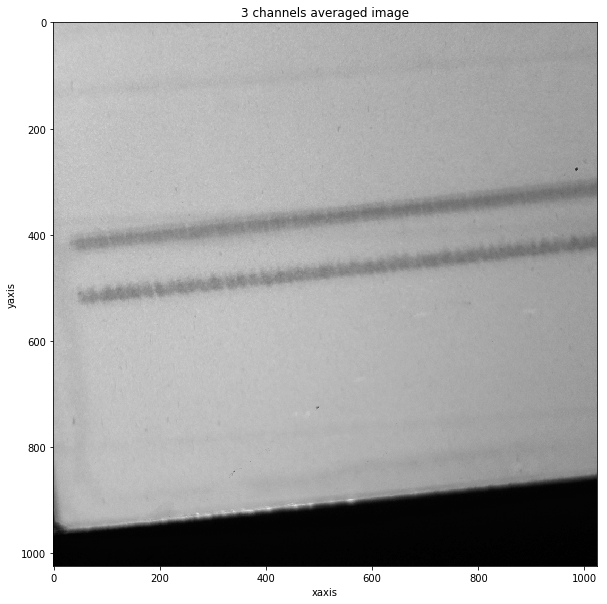

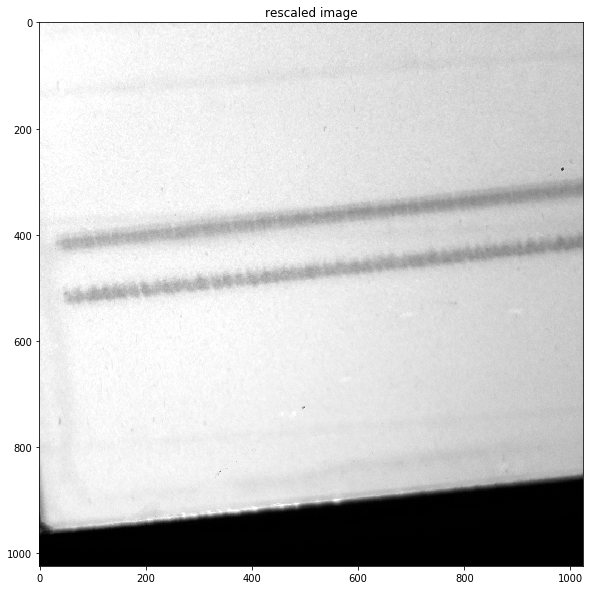

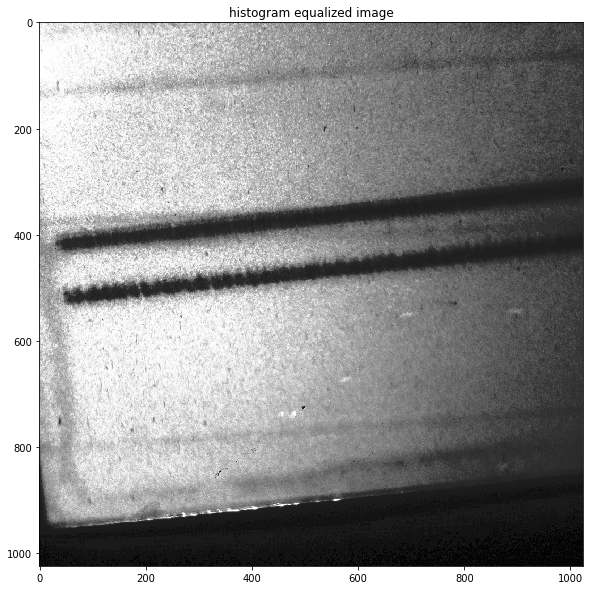

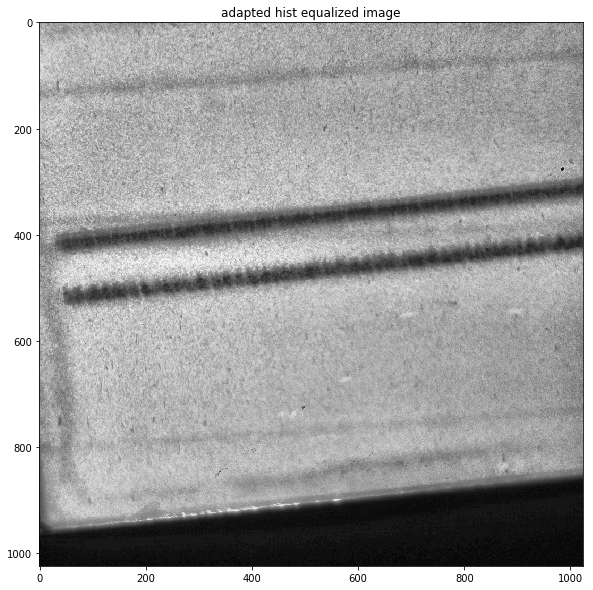

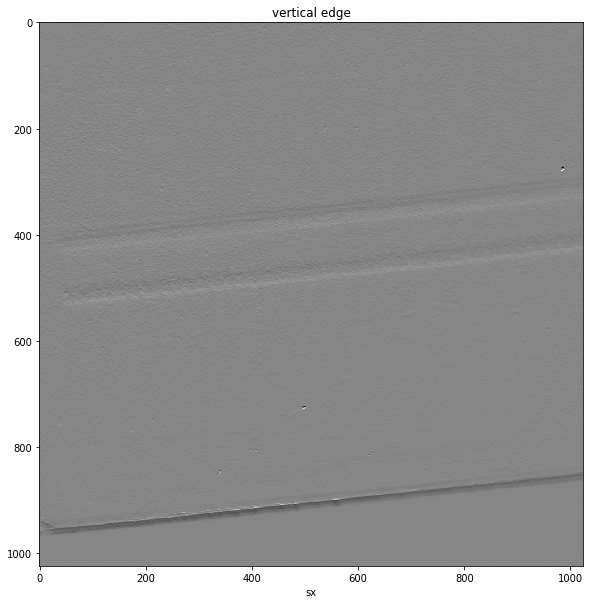

In [146]:
from time import sleep
#from picamera import PiCamera
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import misc
import numpy as np
from scipy import ndimage
import scipy as sp
from sklearn.feature_extraction import image
from skimage import exposure

# read the image, add up three channel and average it, convert to uint8
picture = mpimg.imread('test_7.jpg')
picture_channel=picture.sum(-1)
picture_channel = np.round(picture_channel/3).astype(np.uint8)

# plot the image in gray scale

plt.rcParams['figure.figsize'] = (10,10)
plt.imshow(picture_channel, cmap=plt.cm.gray)
plt.xlabel('xaxis')
plt.ylabel('yaxis')
plt.title('3 channels averaged image')
plt.show()


# Contrast stretching
p2, p98 = np.percentile(picture_channel, (2, 98))
img_rescale = exposure.rescale_intensity(picture_channel, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(picture_channel)

# Adaptive Equalization: this method is used to compensate possible local in-homogenity of the image.
img_eq = exposure.equalize_hist(picture_channel)
img_adapteq = exposure.equalize_adapthist(picture_channel, clip_limit=0.03)
plt.imshow(img_rescale, cmap= plt.cm.gray)
plt.title("rescaled image")
plt.show()
plt.imshow(img_eq, cmap=plt.cm.gray)
plt.title("histogram equalized image")
plt.show()
plt.imshow(img_adapteq, cmap = plt.cm.gray)
plt.title("adapted hist equalized image")
plt.show()

# do sobel edge detection
sx=ndimage.sobel(picture_channel.astype(np.int32), axis=0, mode='mirror')
sy=ndimage.sobel(picture_channel.astype(np.int32), axis=1, mode='mirror')

# plot x and y direction edge

plt.imshow(sx, cmap = plt.cm.gray)
plt.xlabel('sx')
plt.title("vertical edge")
plt.show()

select the area of interest

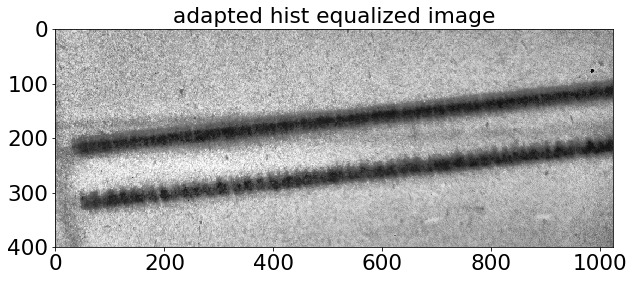

[ 0.8377514   0.8377514   0.8377514  ...,  0.41921397  0.41921397
  0.4979396 ]


In [193]:
# plot the processing area
plt.imshow(img_adapteq[200:600,:], cmap = plt.cm.gray)
plt.title("adapted hist equalized image")
plt.show()
print(img_adapteq[100, :])

In [130]:
# define colorimetric_sensor class
class colorimetric_sensor:

    # constructor
    def __init__(self):
        self.expire = False
        self.O3=0
        self.HCHO=0
        self.NO2=0
        self.humidity=0
        self.temperature=0
        self.time=0
    # locate the common edges for colorimetric sensors
    def get_edge(self, image, position_1, position_2, threshold_precent, window_size):
        # initialize computed edge positions as empty list
        edge = []
        # initialize smoothed_signal as shape(2, image.shape[0]) 2D array
        smoothed_signal = np.ndarray(shape=(2, image.shape[0]), dtype=np.float16)
        # maximum and minimum are the maximum and minimum intensity along two positions on the image
        maximum = [np.max(image[:, position_1]), np.max(image[:, position_2])]
        minimum = [np.min(image[:, position_1]), np.min(image[:, position_2])]
        # edge_level is the threshold_precent multiply sum of max and min
        edge_level = [y+threshold_precent*(x-y) for (x, y) in zip(maximum, minimum)]
        edge_level = np.array(edge_level).astype(np.float32)
      
        # now we do a moving average filtering for the signal to reduce(remove) the gitters(noise) which may 
        # cause ambiguity of edge positions
        window = np.ones(int(window_size))/float(window_size)
        # smooth the three signals
        smoothed_signal[0,:] = np.convolve(image[:, position_1], window, 'same')
        smoothed_signal[1,:] = np.convolve(image[:, position_2], window, 'same')
        
        # we now discard the beginning and end part of the signal
        smoothed_signal = smoothed_signal[:, int(window_size/2): smoothed_signal.shape[1]-int(window_size/2)]
        # now find the position(index) of the edge by using hard thresholding: oneside above(below), 
        # the other size below(above) threshold, there should be eight corssing points
        for j in range(smoothed_signal[0,:].shape[0]-1):
            # this means that there is a crossing for the val
            if (smoothed_signal[0,j]-edge_level[0])*(smoothed_signal[0, j+1]-edge_level[0])<0:
                edge.append(j)
        for j in range(smoothed_signal[1,:].shape[0]-1):
            if (smoothed_signal[1,j]-edge_level[1])*(smoothed_signal[1, j+1]-edge_level[1])<0:
                edge.append(j)
        # now we have edge with 8 numbers 
        # use both smoothing on adaptive histogram equalized image, if edge is not 8, should try using other positions
        if len(edge) != 8:
            print("can not find all edges, try changing threshold_precent!")
        # now we want to find the edge for the sensors, pick the min/max among the three values for each identified edge
        return edge_level, smoothed_signal, edge

    # get_intensity: get the intensity change profile along the identified sensor strip
    def get_intensity(self, image, edge, position_1, position_2):
        # intialize final averaged sensor_intensity
        sensor_intensity=np.empty(shape=[2,image.shape[1]], dtype = np.float16)
        # here we always consider the inclination of sensor compared to horizontal line
        # we get the tan of theta using geometry and obtain the average along the corrected line
        sensor1_center = []
        sensor2_center = []
        sensor1_center.append(int((edge[0]+edge[1])/2)), sensor1_center.append(int((edge[4]+edge[5])/2))
        sensor2_center.append(int((edge[2]+edge[3])/2)), sensor2_center.append(int((edge[6]+edge[7])/2))
        # now determine the width of the drawn edges, which is the smaller width of the two positions, contain two
        # elements corresponding to two sensors
        width = []
        width.append(min(edge[1]-edge[0], edge[5]-edge[4]))
        width.append(min(edge[3]-edge[2], edge[7]-edge[6]))
        tantheta =[]
        tantheta.append((sensor1_center[1]-sensor1_center[0])/(position_2-position_1))
        tantheta.append((sensor2_center[1]-sensor2_center[0])/(position_2-position_1))
        for j in range(image.shape[1]):
            middle = sensor1_center[0]+(j-position_1)*tantheta[0]
            lower = int(middle - 0.5*width[0])
            higher = int(middle + 0.5*width[0])
            sensor_intensity[0,j] = np.mean(image[lower:higher, j])
        for j in range(image.shape[1]):
            middle = sensor2_center[0]+(j-position_1)*tantheta[1]
            lower = int(middle - 0.5*width[1])
            higher = int(middle + 0.5*width[1])
            sensor_intensity[1,j] = np.mean(image[lower:higher, j])
        return sensor_intensity      
            
            
    # get_position: identify the position of the sensor edge given the intensity profile
    def get_position(self, sensor_intensity, threshold):
        # do a slight smoothing for sensor intensity first before looking for the position
        # obtain the intensity max and min in sensor1 area
        idx = [[],[]]
        sensor_min = np.amin(sensor_intensity, axis = 1)
        sensor_max = np.amax(sensor_intensity, axis = 1)
        sensor_mean = list(sensor_min+threshold*(sensor_max - sensor_min))
        for i in range(2):
            for j in range(sensor_intensity.shape[1]-1):
                if (sensor_intensity[i][j]-sensor_mean[i])*(sensor_intensity[i][j+1]-sensor_mean[i]) < 0:
                    idx[i].append(j)
        a = int(np.mean(idx[0]))
        b = int(np.mean(idx[1]))
        return sensor_max, sensor_intensity, [a,b]

# intensity profile using originral image, can not find common edge due to increase in brightness, contrast is not averaged

[192, 226, 292, 325, 126, 165, 232, 261]


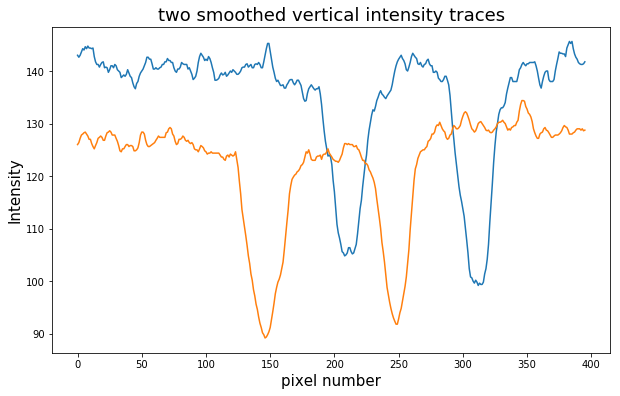

In [131]:
sensor = colorimetric_sensor()
edge_level, X, edge=sensor.get_edge(picture_channel[200:600,:], 100, 700, 0.6, 5)
print(edge)
plt.figure(figsize = (10, 6))
plt.plot(X[0,:])
plt.plot(X[1,:])
plt.xlabel("pixel number", fontsize = 15)
plt.ylabel("Intensity", fontsize=15)
plt.title("two smoothed vertical intensity traces", fontsize=18)
plt.show()

# intensity profile with adapted histogram equalization, can locate right number of edge due to averaged contrast level across the image

[192, 226, 292, 326, 130, 163, 233, 260]


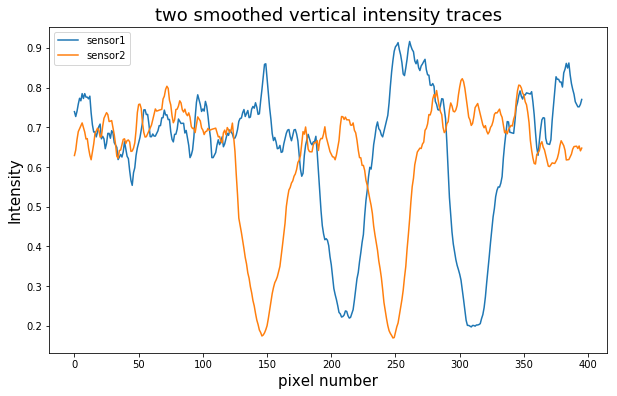

In [132]:
sensor = colorimetric_sensor()
edge_level, X, edge=sensor.get_edge(img_adapteq[200:600,:], 100, 700, 0.4, 5)
print(edge)
plt.figure(figsize = (10, 6))
plt.plot(X[0,:], label="sensor1")
plt.plot(X[1,:], label = "sensor2")
plt.xlabel("pixel number", fontsize = 15)
plt.ylabel("Intensity", fontsize=15)
plt.title("two smoothed vertical intensity traces", fontsize=18)
plt.legend()
plt.show()

# can not find final sensor edge due to slight background illumunation inhomogenity

In [143]:
sensor_intensity = sensor.get_intensity(picture_channel[200:600,:], edge, 100, 800)
sensor_max, sensor_intensity, idx=sensor.get_position(sensor_intensity,0.5)
print(sensor_intensity.shape)
print(edge_level)
print(edge)
print(sensor_intensity.shape)
print(sensor_max)
print(idx)

(2, 1024)
[ 0.48974609  0.43286133]
[192, 226, 292, 326, 130, 163, 233, 260]
(2, 1024)
[ 134.125  136.75 ]
[113, 246]


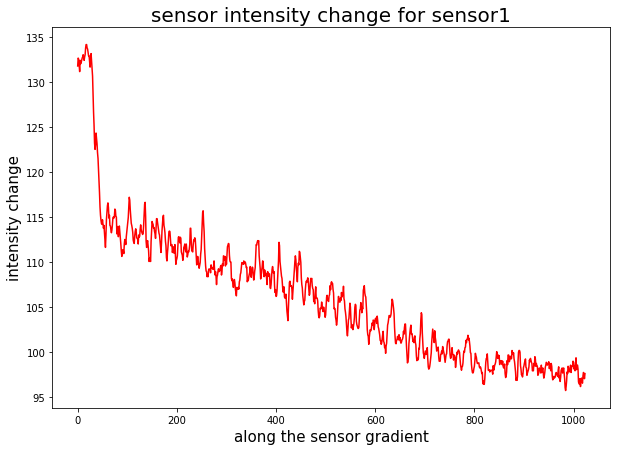

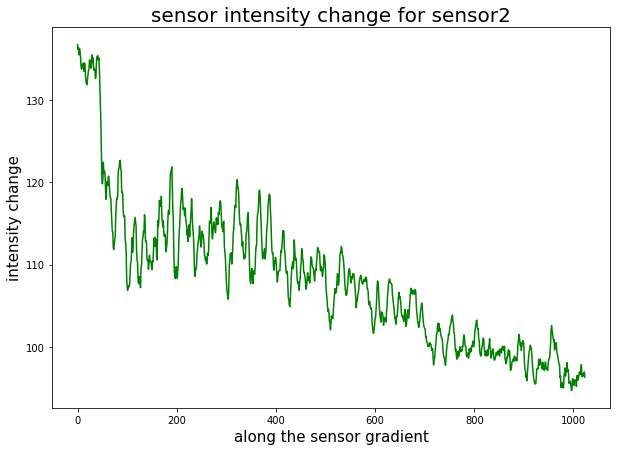

In [125]:
# plot the averaged sensor intensity along the direction of gradient
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[0,:], color = 'r')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor1", fontsize=20)
plt.show()
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[1,:], color = 'green')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor2", fontsize=20)
plt.show()


# can find the final sensor edge using adapted histogram equalization

In [144]:
sensor_intensity = sensor.get_intensity(img_adapteq[200:600,:], edge, 100, 800)
sensor_max, sensor_intensity, idx=sensor.get_position(sensor_intensity, 0.55)
print(sensor_intensity.shape)
print(edge_level)
print(edge)
print(sensor_intensity.shape)
print(sensor_max)
print(idx)

(2, 1024)
[ 0.48974609  0.43286133]
[192, 226, 292, 326, 130, 163, 233, 260]
(2, 1024)
[ 0.61914062  0.67773438]
[32, 46]


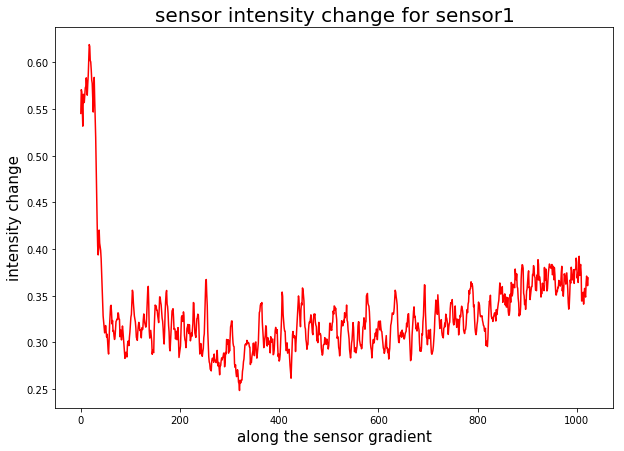

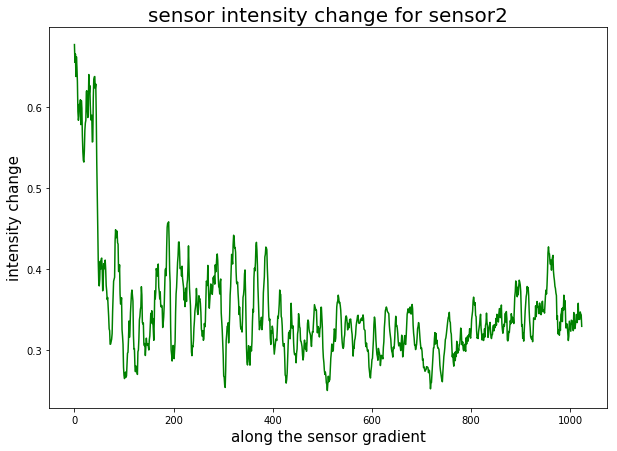

In [147]:
# plot the averaged sensor intensity along the direction of gradient
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[0,:], color = 'r')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor1", fontsize=20)
plt.show()
plt.figure(figsize = (10,7))
plt.plot(sensor_intensity[1,:], color = 'green')
plt.xlabel("along the sensor gradient", fontsize=15)
plt.ylabel("intensity change", fontsize=15)
plt.title("sensor intensity change for sensor2", fontsize=20)
plt.show()

#several comments
#1. the algorithms recorrects any deviation of sensor trace compared to horizontal direction

#2. each class function is sensitive to background illumination fluctuation hence ideally should have homogeneous lighting

#3. adapted histogram equalized image can rebalance the contrast of background but tend to introduce more local intensity flutuation, tradeoff here

#4. good result can be obtained by setting right threshold values, which remains to be a tuning parameter, and its effects on sensor sensitivity remains to be studied

#here plot histogram of original, histogram equalization and adapted histogram equalization. it can be seen histogram equalization spread out pixel intensity into full range and adapted histogram equalization enhance contrasts within each tiles

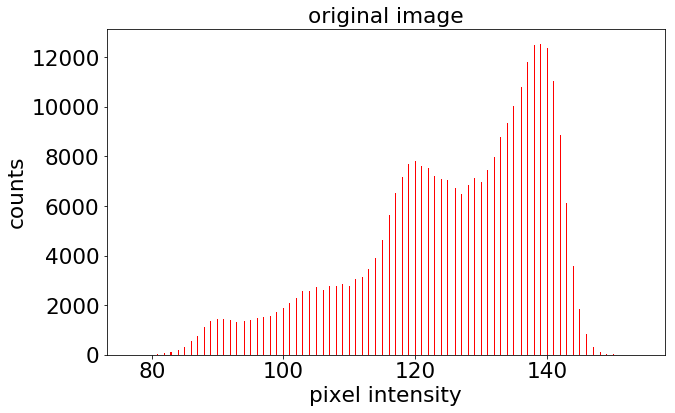

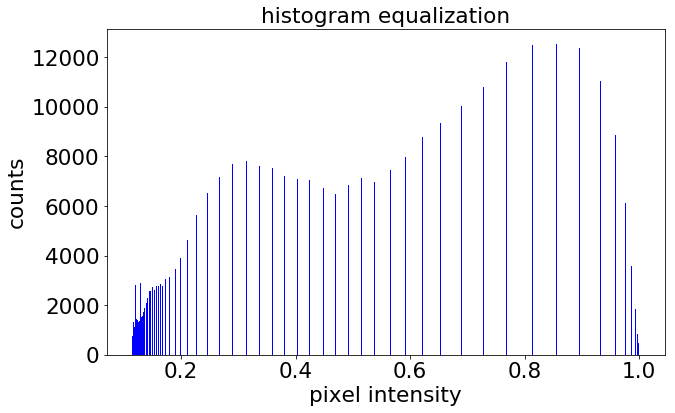

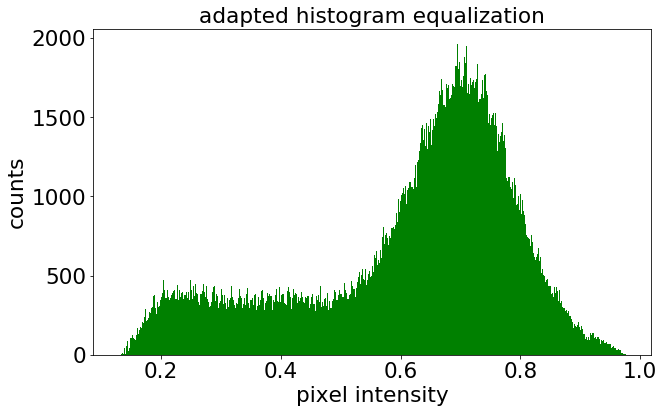

In [194]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',}
plt.rcParams.update(params)
plt.rc('font',size = 15)

image1 = picture_channel[300:600,:].reshape(300*1024,1)
image2 = img_eq[300:600,:].reshape(300*1024,1)
image3 = img_adapteq[300:600,:].reshape(300*1024,1)

plt.hist(image1, bins = 500, color = 'r')
plt.xlabel("pixel intensity")
plt.ylabel("counts")
plt.title('original image')
plt.show()
plt.hist(image2, bins = 500, color = 'b')
plt.xlabel("pixel intensity")
plt.ylabel("counts")
plt.title('histogram equalization')
plt.show()
plt.hist(image3, bins = 500, color = 'g')
plt.xlabel("pixel intensity")
plt.ylabel("counts")
plt.title('adapted histogram equalization')
plt.show()